In [1]:
import os
import ssl
import glob
from IPython import display
from irods.session import iRODSSession
try:
    env_file = os.environ['IRODS_ENVIRONMENT_FILE']
except KeyError:
    env_file = os.path.expanduser('~/.irods/irods_environment.json')

ssl_context = ssl.create_default_context(
        purpose=ssl.Purpose.SERVER_AUTH,
        cafile=None, capath=None, cadata=None
        )
ssl_settings = {'ssl_context': ssl_context}

session = iRODSSession(irods_env_file=env_file, **ssl_settings)

home_dir = "/ghum/home/ghum_pilot034/"
dataset_dir = home_dir + 'DATASET_2/'
output_dir = home_dir + 'TEAM_2/'

vsc_user = "vsc35516"
scratch_dir = f"/scratch/leuven/{vsc_user[3:6]}/{vsc_user}/"

In [19]:
import torch
torch.cuda.is_available()

True

In [2]:
# list all images in scratch dir
scratch_img_dir = scratch_dir + 'DATASET_2/IE3562253/REP3562255/*.jpg'
import glob
scratch_imgs = glob.glob(scratch_img_dir)
print(len(scratch_imgs))

701


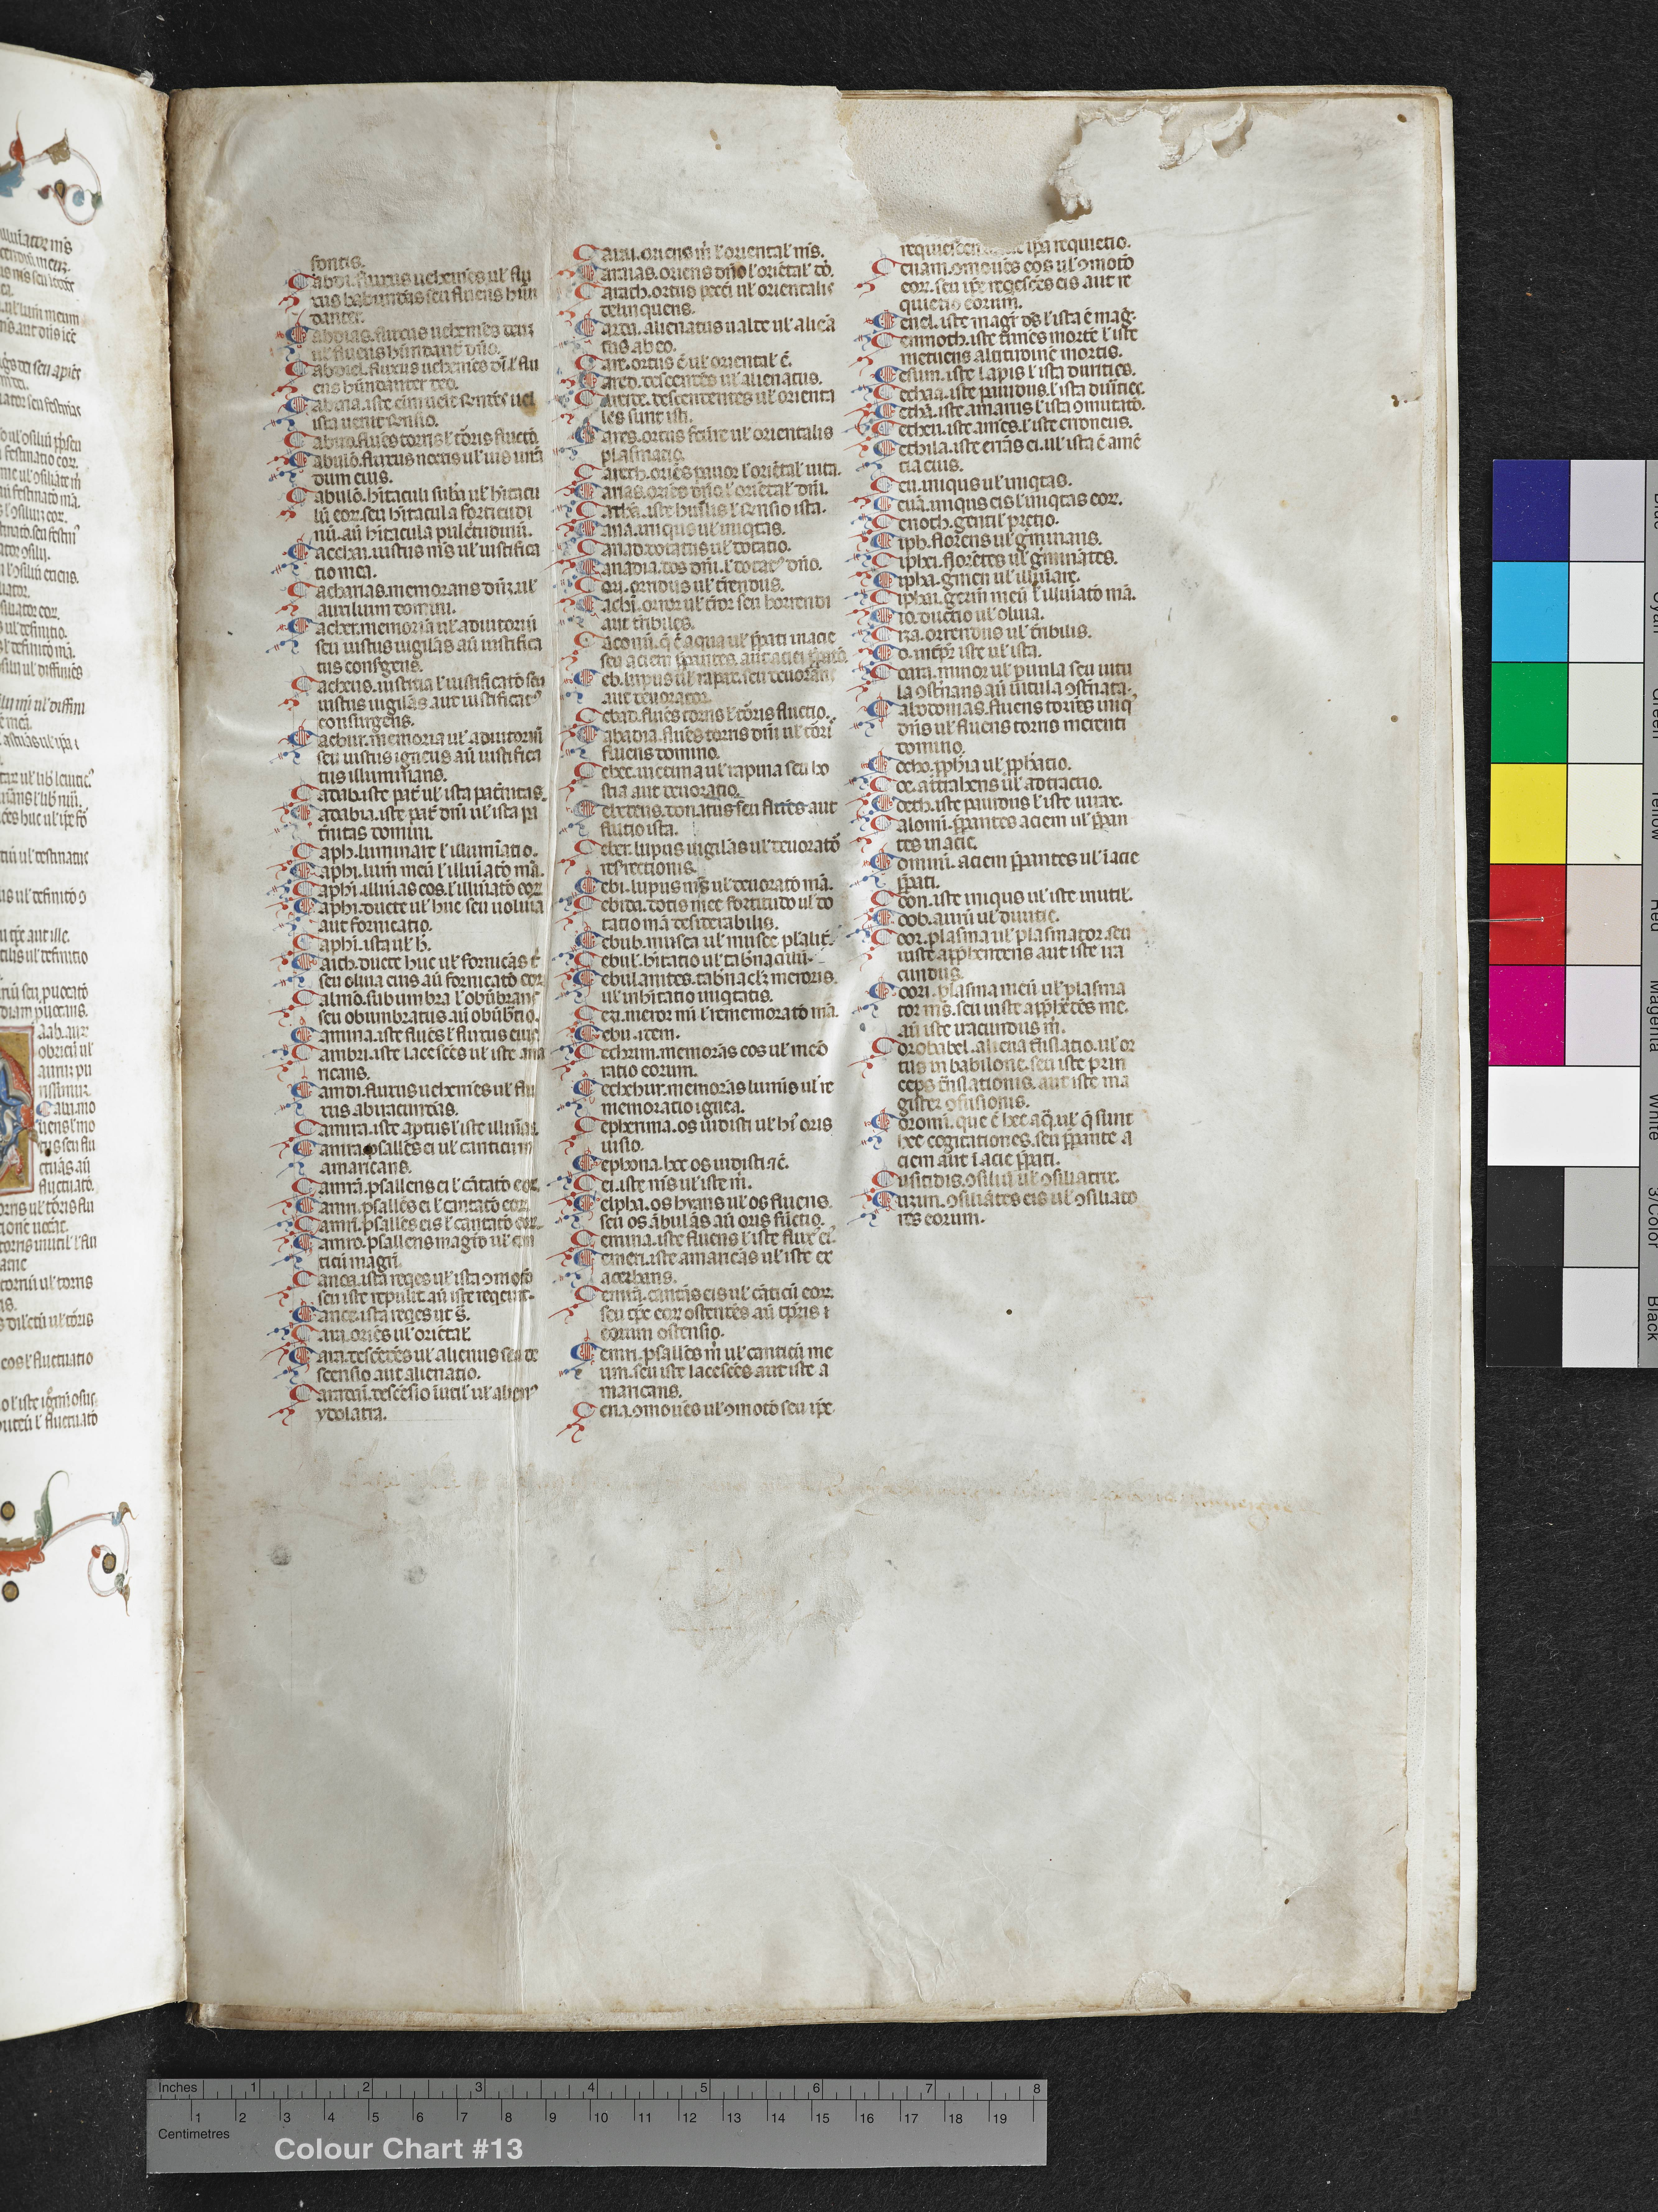

In [53]:
# import one image from scratch dir
folio_nr = '691'
test_im = glob.glob(scratch_dir + 'DATASET_2/IE3562253/REP3562255/*_{}_*.jpg'.format(folio_nr))[0]
display.Image(test_im)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import torch

/data/leuven/355/vsc35516/miniconda3/envs/envirods/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# info about the image
image = Image.open(test_im)
print("filename: ", image. filename)
print("Format: ", image.format)
print("Mode: ", image.mode)
print("Width: ", image.width)
print("Height: ", image.height)
image.show()

filename:  /scratch/leuven/355/vsc35516/DATASET_2/IE3562253/REP3562255/FL3562312_39_VIEW_MAIN.jpg
Format:  JPEG
Mode:  RGB
Width:  5336
Height:  7121


/scratch/leuven/355/vsc35516/DATASET_2/IE3562253/REP3562255/FL3563339_690_VIEW_MAIN.jpg


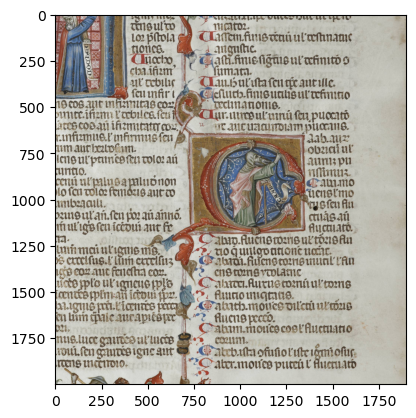

In [48]:
# reading image in cv2 and cropping it
print(test_im)
img_bgr = cv2.imread(test_im)
im_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# plt.imshow(im_rgb)
# # plt.rcParams["figure.figsize"] = (20,20)
# plt.show()

# crop height and widths
# w_0, w_1 = 3500,4500
# h_0, h_1 = 580,4600

w_0, w_1 = 2800,4700
h_0, h_1 = 3000,5000

snip_RGB = im_rgb[h_0:h_1,w_0:w_1]
snip_BGR = img_bgr[h_0:h_1,w_0:w_1]
plt.imshow(snip_RGB)
plt.show()

In [49]:
# save crop locally
name = 'bigQ'
filename = './{}_w_bg_{}.jpg'.format(folio_nr,name)
cv2.imwrite(filename,snip_BGR)

True

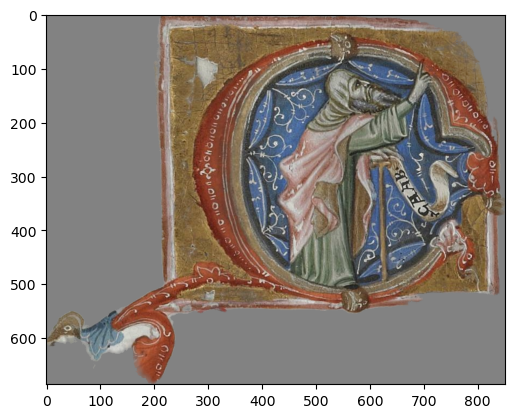

In [50]:
# remove background
from carvekit.api.high import HiInterface

# Check doc strings for more information
interface = HiInterface(object_type="object",  # Can be "object" or "hairs-like". # object = tracer_b7
                        batch_size_seg=5,
                        batch_size_matting=1,
                        device='cuda' if torch.cuda.is_available() else 'cpu',
                        seg_mask_size=640,  # Use 640 for Tracer B7 and 320 for U2Net
                        matting_mask_size=2048,
                        trimap_prob_threshold=231,
                        trimap_dilation=30,
                        trimap_erosion_iters=5,
                        fp16=False)
images_without_background = interface([filename])
image_wo_bg = images_without_background[0]
image_wo_bg = image_wo_bg.crop(image_wo_bg.getbbox()) # remove empty pixels

# save image to scratch
# image_cropped_path = scratch_dir + 'image_crops/small_initials/' + save_name[:-4] + '.png' # must be png to contain transparency information
# save image locally
image_cropped_path = './{}_wo_bg_{}.png'.format(folio_nr,name)
image_wo_bg.save(image_cropped_path)

# reading image in cv2 and cropping it
img = cv2.imread(image_cropped_path)
im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)
# plt.rcParams["figure.figsize"] = (20,20)
plt.show()

In [51]:
# moving image from scratch to ManGO
# print(image_cropped_path.split('/')[-1])
suzanna_team_dir = home_dir + 'TEAM_2/output_suzanna'
session.data_objects.put(image_cropped_path, suzanna_team_dir + '/background_removed/' + image_cropped_path.split('/')[-1])